(rv)=

# Radial velocity fitting

In [1]:
import sys
sys.version

'3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) \n[Clang 11.1.0 ]'

In [2]:
import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


Fitting RVs for Earth and Jupiter

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278- T_subtract
omega_jup = np.radians(274.3)- 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(0) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000- T_subtract
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000- T_subtract
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:294: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:362: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


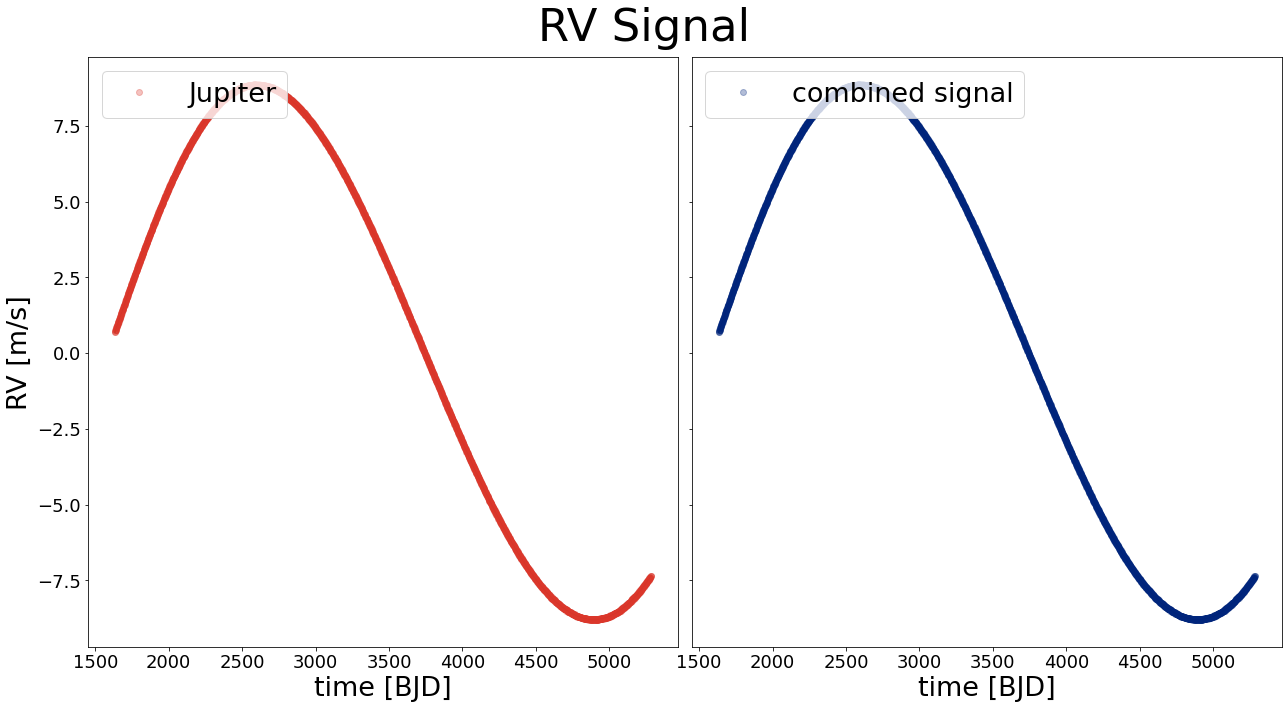

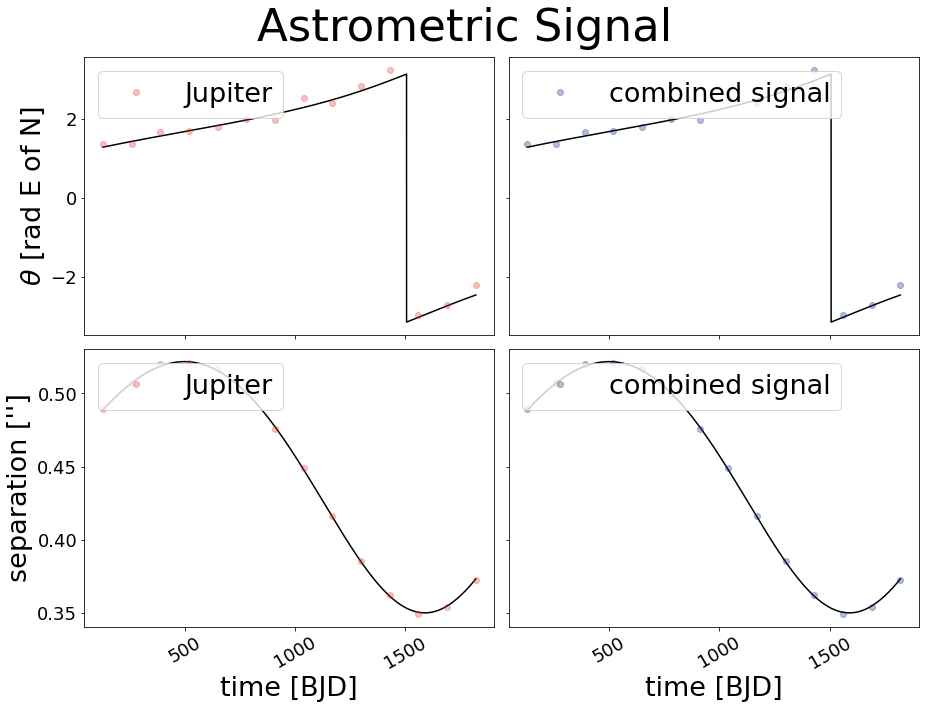

In [9]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = orbit_params_jup

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii)

n_planets = 1
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.001
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#db372b', '#00257c'],
    ['Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



<ErrorbarContainer object of 3 artists>

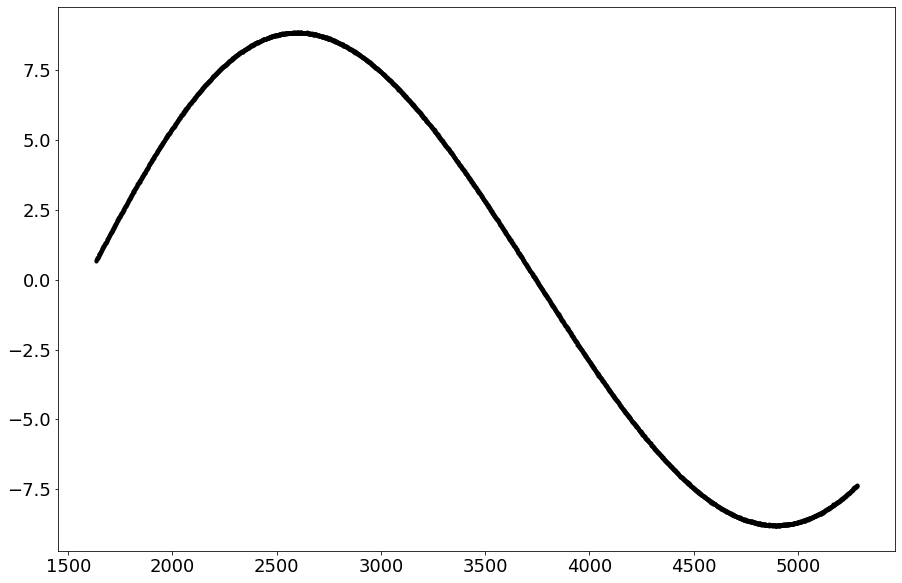

In [10]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results





x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

We will have a sense of the periods of the planets, so we can use the `exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [50]:
periods = [4327.631]
period_errs = [10]
t0s = [2457740.80985712- T_subtract]
t0_errs = [10]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err, t0s=t0s)
print(Ks, "m/s")

[8.7369675] m/s


In [13]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([0.00231074])

In [14]:
np.array(period_errs) / np.array(periods)


array([0.00231073])

## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [51]:
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    
    ## Gaussian priors based on previous modeling
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=1, testval = t0s)
    
    #log normal prior on period around estimates
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=50*np.array(period_errs) / np.array(periods),
        shape=1,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide normal prior for semi-amplitude
    K = pm.Normal("K", mu=Ks, sd=5, shape=1, testval=Ks)
    

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 1), testval=0.01 * np.ones((2, 1)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=0.01)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{exp,no_inplace}(logK), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

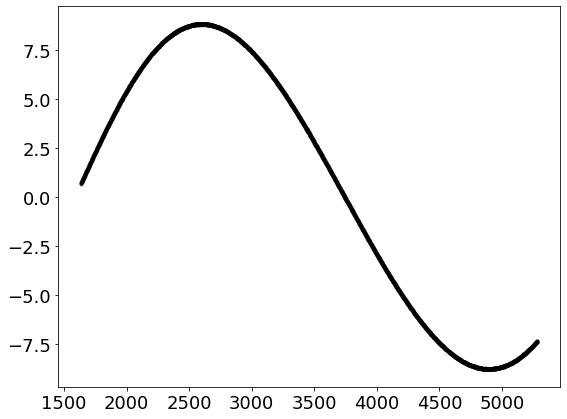

In [52]:
plt.figure(figsize=[9,7])
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha=0.5)
with model:
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the full model is the blue line and the data are the black points

It looks pretty good already, but let's still fit for the maximum a posterior parameters.

In [36]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[t0, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [logs, logP, logK, t0]


message: Optimization terminated successfully.
logp: -604790.0508463798 -> -24343.389048867553
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -24343.389048867553 -> -19300.356069957303
optimizing logp for variables: [logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -19300.356069957303 -> 9269.45601603905


[3740.72681533]


Text(0.5, 1.0, 'MAP model only')

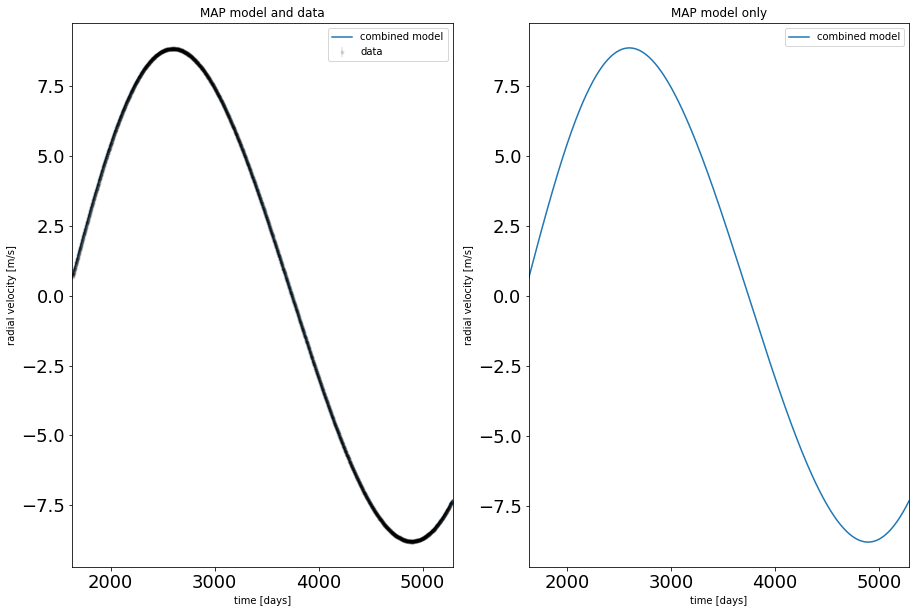

In [37]:
fig, ax = plt.subplots(1,2, figsize = [15,10])
print(map_soln['t0'])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.1, label='data')
ax[0].plot(t, map_soln["rv_model_pred"], label="combined model")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")

ax[1].plot(t, map_soln["rv_model_pred"], label="combined model")
ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")


That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [38]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, ecs, logK, logP, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 129 seconds.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [39]:
import arviz as az

az.summary(
    trace, var_names=["logs", "omega", "ecc", "t0", "K", "P", "ecs"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logs,-4.669,0.009,-4.686,-4.651,0.000,0.000,1234.0,1307.0,1.0
omega[0],-1.496,0.001,-1.498,-1.495,0.000,0.000,1465.0,1460.0,1.0
ecc[0],0.048,0.000,0.048,0.049,0.000,0.000,1930.0,1342.0,1.0
t0[0],3740.725,0.063,3740.613,3740.851,0.002,0.001,1533.0,1166.0,1.0
K[0],8.821,0.000,8.821,8.822,0.000,0.000,1490.0,1368.0,1.0
P[0],4327.751,0.213,4327.344,4328.137,0.006,0.004,1312.0,1417.0,1.0
"ecs[0,0]",0.016,0.000,0.016,0.017,0.000,0.000,1479.0,1460.0,1.0
"ecs[1,0]",-0.219,0.000,-0.220,-0.219,0.000,0.000,1847.0,1397.0,1.0


<ipython-input-40-1bfdf35216d2>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=["logs", "P", "logK", "ecc", "omega"])


array([[<AxesSubplot:title={'center':'logs'}>,
        <AxesSubplot:title={'center':'logs'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'logK'}>,
        <AxesSubplot:title={'center':'logK'}>],
       [<AxesSubplot:title={'center':'ecc'}>,
        <AxesSubplot:title={'center':'ecc'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>]], dtype=object)

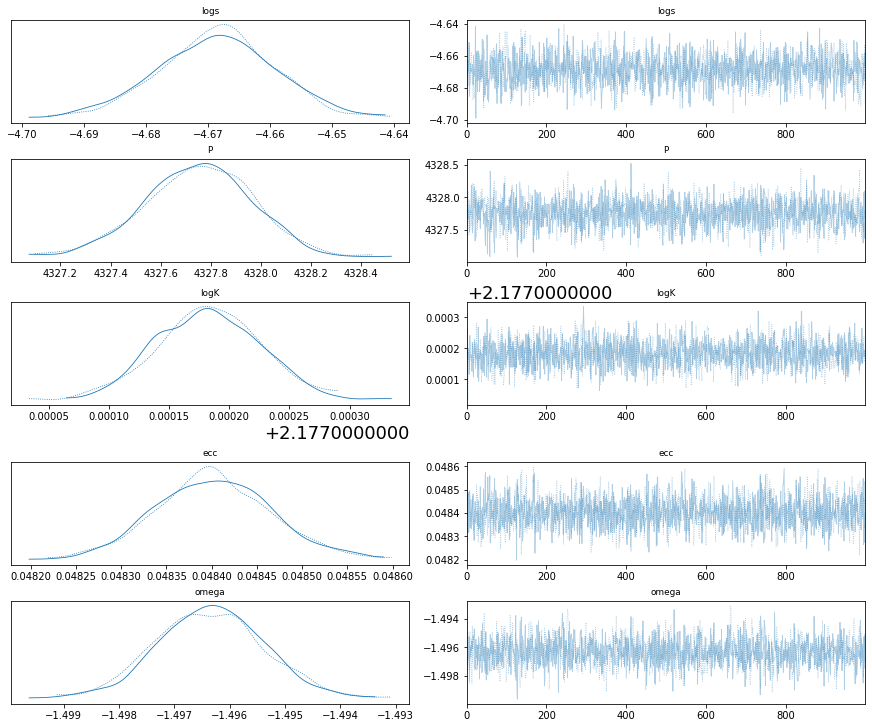

In [40]:
pm.traceplot(trace, var_names=["logs", "P", "logK", "ecc", "omega"])


It looks like everything is pretty much converged here. 

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

In [41]:
m_sun = 333030
def semi_amplitude(m_planet, period, ecc, inclination):
    K = 28.4329/(np.sqrt(1-ecc**2.)) * (m_planet*np.sin(inclination) / m_jup) \
    *((m_planet+m_sun) / m_sun)**(-2/3) * (period / 365.256) ** (-1/3)
    
    return K



In [42]:
K_earth = semi_amplitude(m_earth, P_earth, e_earth, inclination_earth)
K_jup = semi_amplitude(m_jup, P_jup, e_jup, inclination_jup)

print(K_jup)

8.829399101728361


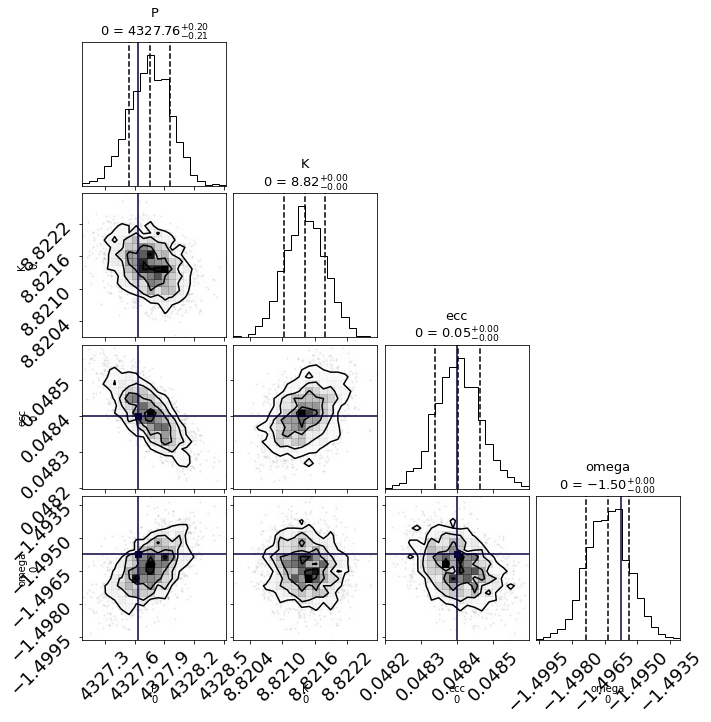

In [49]:
import corner

truth = [P_jup, K_jup, e_jup, omega_jup]
with model:
    _ = corner.corner(trace, var_names=["P", "K", "ecc", "omega"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}, truths = truth, truth_color = "#03003a")

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

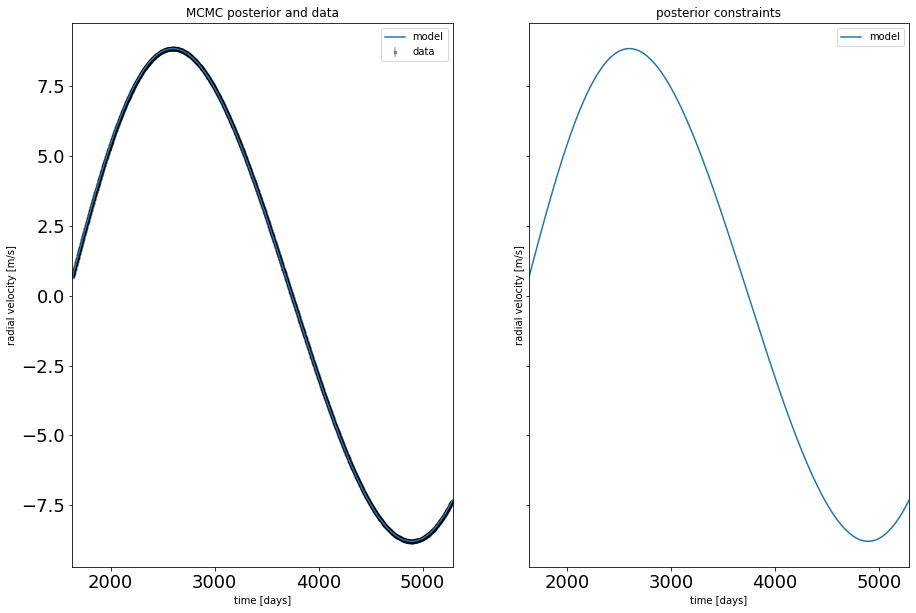

In [44]:
# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))

fig, ax = plt.subplots(1,2, figsize = [15,10], sharey=True)

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.3, label='data', zorder = 0)
ax[0].plot(t, pred[1], color="C0", label="model", zorder = 1)
art = ax[0].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MCMC posterior and data")




ax[1].plot(t, pred[1], color="C0", label="model")
art = ax[1].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")



plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

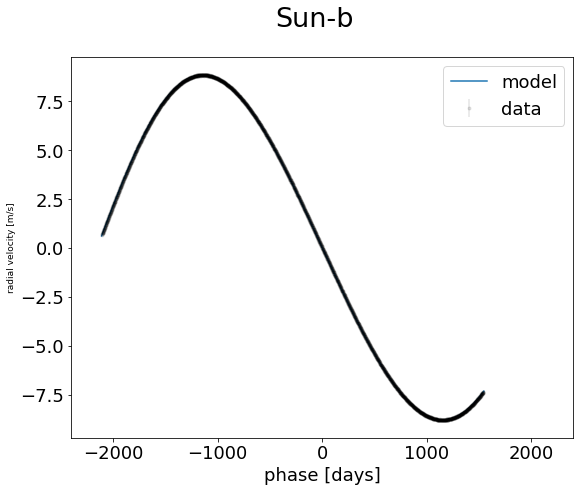

In [45]:
for n, letter in enumerate("b"):
    fig, ax = plt.subplots(1,1, figsize = [9,7], sharey=True)

    
    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])


    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    ax.errorbar(x_fold, y_rv, yerr=y_rv_err, fmt=".k", label = "data", alpha = 0.1)

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["rv_model_pred"].values[:, :, inds],
        [16, 50, 84],
        axis=(0, 1),
    )
    ax.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = ax.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.9
    )
    art.set_edgecolor("none")
    
    
    
    
    
    
    

    ax.legend(fontsize=18)
    plt.xlim(-0.5 * p, 0.5 * p)
    ax.set_xlabel("phase [days]", fontsize=18)
    ax.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax.set_xlim(-p/1.8, p/1.8)
    fig.suptitle("Sun-{0}".format(letter), fontsize=27)

In [46]:
parameters = ["P", "K", "ecc", "omega", "t0", "ecs"]
param_medians = {}
posterior1 = {}
for param in parameters:
    posterior1[param]=np.concatenate(trace.posterior[param].values[:, :,])
    print(posterior1[param])
    
    print(param + " median")
    planet1_med = np.median(trace.posterior[param].values[:, :,])
    print(planet1_med)
    
    param_medians[param]=[planet1_med]
    print("")

[[4328.25301021]
 [4327.40586989]
 [4327.75780481]
 ...
 [4327.35987629]
 [4327.7963963 ]
 [4327.73423615]]
P median
4327.758005456222

[[8.82060992]
 [8.82159154]
 [8.82212794]
 ...
 [8.82122743]
 [8.82137108]
 [8.82138901]]
K median
8.821419296677174

[[0.04833239]
 [0.0484779 ]
 [0.04846046]
 ...
 [0.04845677]
 [0.0483324 ]
 [0.0483674 ]]
ecc median
0.0484013088493071

[[-1.49428615]
 [-1.49714977]
 [-1.49756775]
 ...
 [-1.49609645]
 [-1.49504367]
 [-1.49747905]]
omega median
-1.496343530706099

[[3740.65724422]
 [3740.75142934]
 [3740.75446309]
 ...
 [3740.65930193]
 [3740.65877784]
 [3740.75215532]]
t0 median
3740.725377980575

[[[ 0.01680407]
  [-0.21920314]]

 [[ 0.01620062]
  [-0.21958016]]

 [[ 0.01610594]
  [-0.21954739]]

 ...

 [[ 0.01642832]
  [-0.2195151 ]]

 [[ 0.01663802]
  [-0.21921583]]

 [[ 0.01610993]
  [-0.21933507]]]
ecs median
-0.10162797975764438



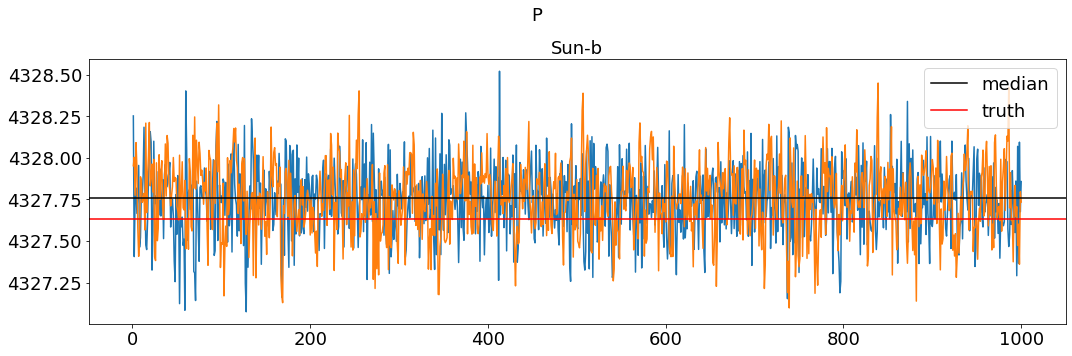

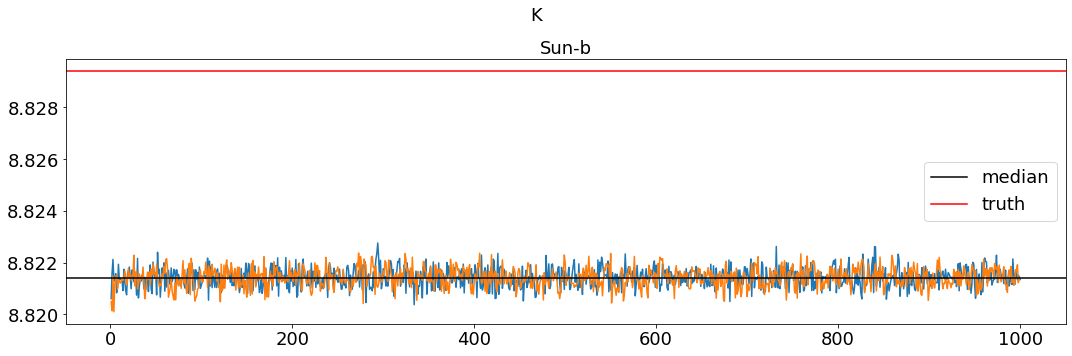

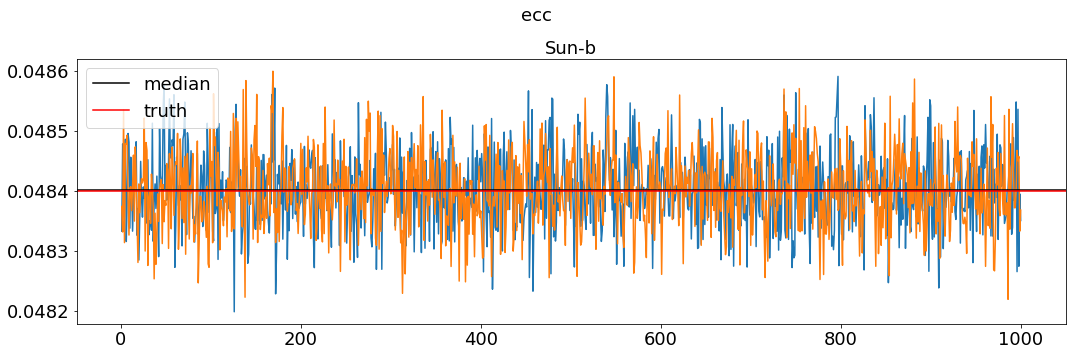

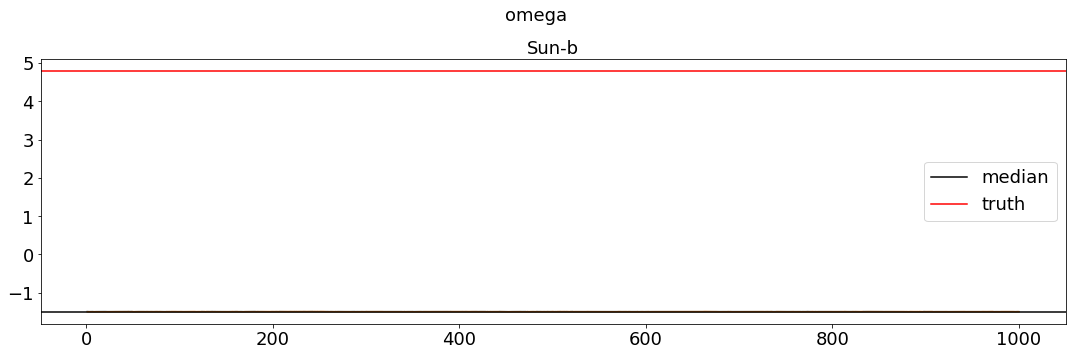

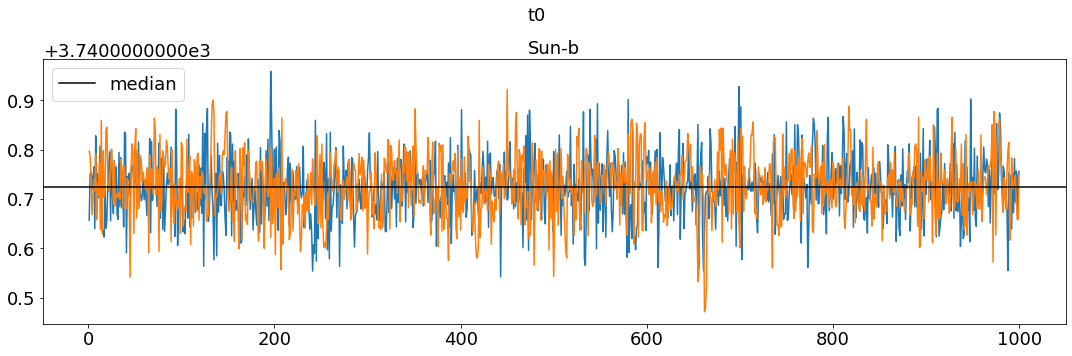

In [47]:
parameters = ["P", "K", "ecc", "omega", "t0"]
for ii in range(0, len(parameters)):
    plot_truth = False
    param = parameters[ii]
    
    if ii < 4:
        true_vals_earth = truth[ii]
        plot_truth = True
    
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    planet1_chain1 = trace.posterior[param].values[:, :,][0]
    planet1_chain2 = trace.posterior[param].values[:, :,][1]
    
    
    
    nstep = np.arange(1, len(planet1_chain1)+1, 1)
    
    
    ax.plot(nstep, planet1_chain1)
    ax.plot(nstep, planet1_chain2)
    ax.axhline(y=param_medians[param][0], color = 'k', label = 'median')
    
    if plot_truth:
        ax.axhline(y=true_vals_earth, color = 'r', label = 'truth')
    ax.set_title("Sun-b", fontsize = 18)
    ax.legend(fontsize = 18)
    
    
    fig.suptitle(param, fontsize = 18)
    fig.tight_layout()
    plt.show()

Ok, now let's fold in astrometric observations

(astrometric)=

# Astrometric fitting

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

Text(0.5, 0, 'time [years]')

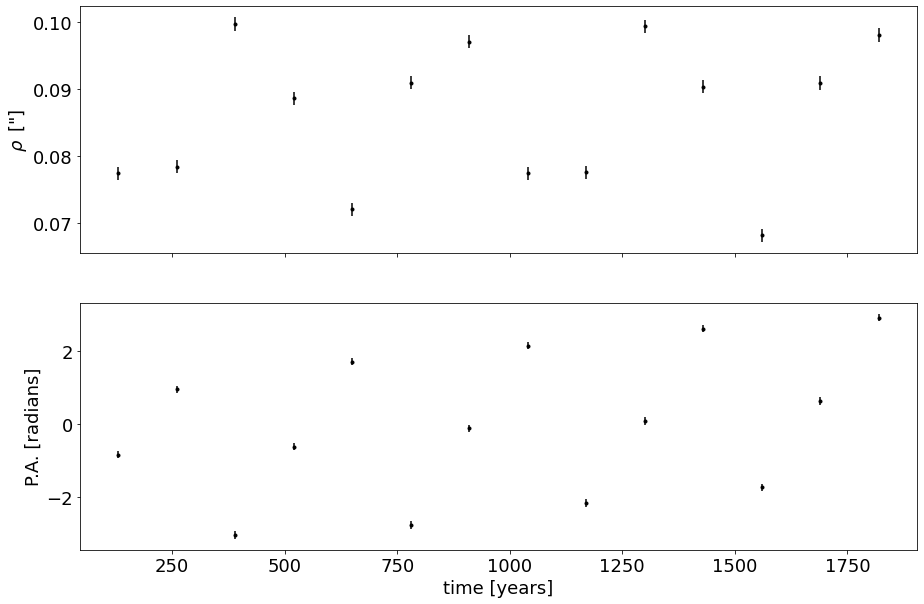

In [503]:
[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]




x_astrometry = np.array(times_observed_astrometry)
theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), .1)
rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), .001)


# Also make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)


fig,ax = plt.subplots(2, figsize=[15,10], sharex=True)

ax[0].errorbar(x_astrometry, rho_data, yerr=rho_err, ls = '', marker = '.', color = 'k')
ax[0].set_ylabel(r'$\rho\,$ ["]', fontsize = 18)

ax[1].errorbar(x_astrometry, theta_data, yerr=theta_err, ls = '', marker = '.', color = 'k')
ax[1].set_ylabel(r"P.A. [radians]", fontsize = 18)
ax[1].set_xlabel("time [years]", fontsize = 18)






## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

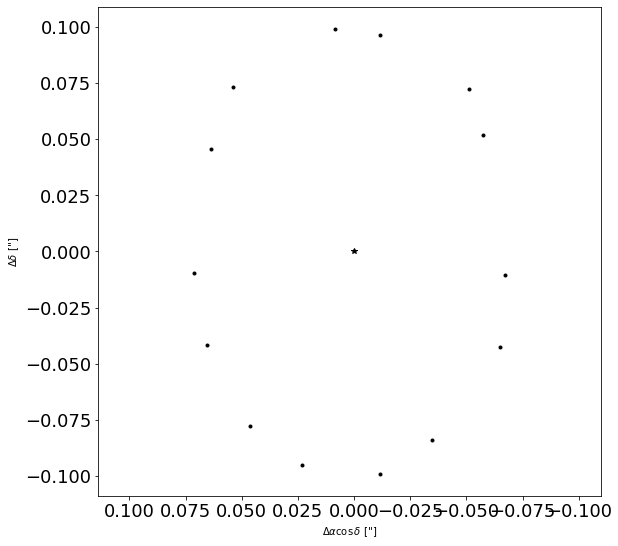

In [504]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(9, 9))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")





## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample.

In [505]:
print(param_medians)





{'P': [365.20814237001474], 'K': [0.06367348719980487], 'ecc': [0.008121771282332765], 'omega': [1.5650228245006428], 't0': [103.23075553049087], 'ecs': [0.03321465883459224]}


In [506]:
P_RV = np.array(param_medians['P'])
K_RV = np.array(param_medians['K'])
t0_RV = np.array(param_medians['t0'])
ecc_RV = np.array(param_medians['ecc'])
omega_RV = np.array(param_medians['omega'])


In [507]:
#determine minimum mass estimate

m_sun = 333030
def min_mass(K, period, ecc):
    m_planet = K/((333030*m_jup)*28.4329/(np.sqrt(1-ecc**2.)) \
                  *(m_sun)**(-2/3) * (period / 365.256) ** (-1/3))

    return m_planet/m_sun



In [508]:
min_masses_RV = min_mass(K_RV, P_RV, ecc_RV)
print(min_masses_RV)
print(min_mass(truth[1], truth[0], truth[2]))
print(m_earth)



[1.01644029e-07]
1.0098754164145339e-07
3.00273e-06


In [509]:
print(truth)
P_true  = np.array(truth[0])
tper_true  = np.array([Tper_earth])
ecc_true  = np.array(truth[2])
omega_true  = np.array(truth[3])
min_mass_true = np.array([min_mass(truth[1], truth[0], truth[2])])



[365.256, 0.06326621319697447, 0.0167, 1.7959438003021653]


In [512]:

from aesara_theano_fallback import aesara as theano

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the parameter estimates from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
parallax = 0.1  # arcsec 
e = param_medians['ecc']
omega = param_medians['omega'] 
P = param_medians['P']  # days
t0 = param_medians['t0'] #BJD


# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    t0=t0_RV, period=P_RV, ecc=ecc_RV, omega=omega_RV, m_p = min_masses_RV)

orbit_true = xo.orbits.KeplerianOrbit(
    t_periastron=tper_true, period=P_true, ecc=ecc_true, omega=omega_true, 
    m_p = np.array([min_mass_true]))



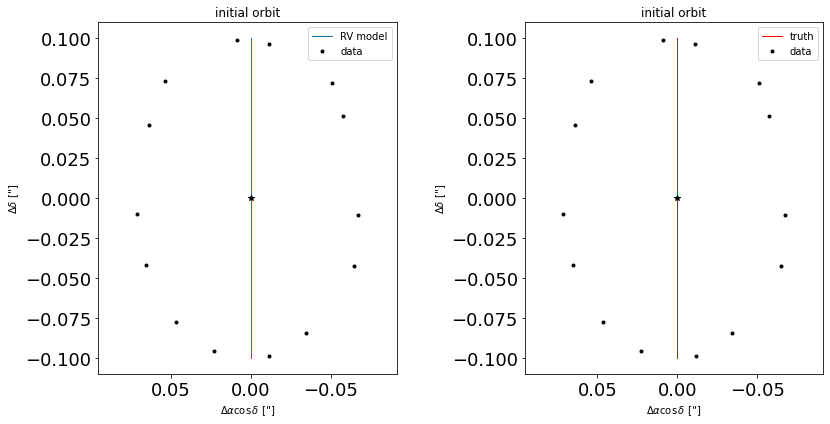

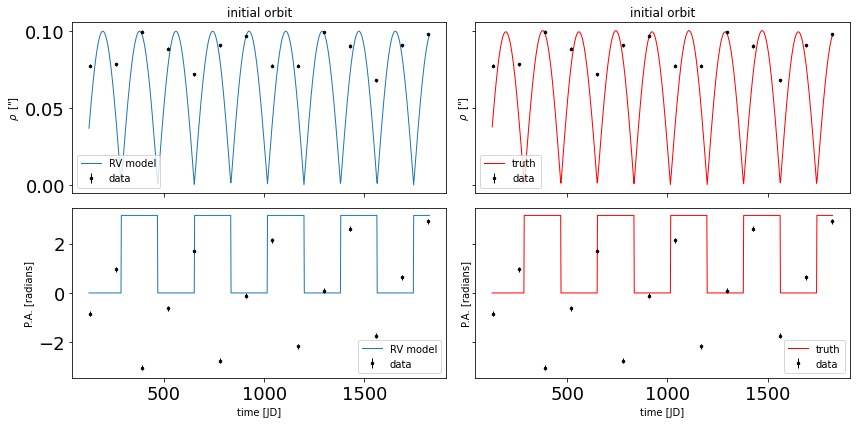

In [513]:

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
rho, theta = theano.function([], orbit.get_relative_angles(t_astrometry, parallax))()
rho_true, theta_true = theano.function([], orbit_true.get_relative_angles(t_astrometry, parallax))()


# Plot the orbit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax0, ax1 = ax[0], ax[1]

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax0.plot(ys, xs, color="C0", lw=1, label = "RV model")

xs_true = rho * np.cos(theta)  # X is north
ys_true = rho * np.sin(theta)  # Y is east
ax1.plot(ys_true, xs_true, color="r", lw=1, label = "truth")

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax0.plot(ys, xs, ".k", label = "data")
ax1.plot(ys, xs, ".k", label = "data")

ax0.set_ylabel(r"$\Delta \delta$ ['']")
ax0.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax0.invert_xaxis()
ax0.plot(0, 0, "k*")
ax0.set_aspect("equal", "datalim")
ax0.set_title("initial orbit")
ax0.legend()

ax1.set_ylabel(r"$\Delta \delta$ ['']")
ax1.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax1.invert_xaxis()
ax1.plot(0, 0, "k*")
ax1.set_aspect("equal", "datalim")
ax1.set_title("initial orbit")
ax1.legend()

fig.tight_layout()


fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(12, 6))
ax[0][0].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5, label = "data")
ax[0][0].plot(t_astrometry, rho, color="C0", lw=1, label="RV model")
ax[0][0].set_ylabel(r'$\rho\,$ ["]')
ax[0][0].set_title("initial orbit")
ax[0][0].legend()

ax[0][1].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5, label = "data")
ax[0][1].plot(t_astrometry, rho_true, color="r", lw=1, label="truth")
ax[0][1].set_ylabel(r'$\rho\,$ ["]')
ax[0][1].set_title("initial orbit")
ax[0][1].legend()




ax[1][0].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5, label = "data")
ax[1][0].plot(t_astrometry, theta, color="C0", lw=1, label="RV model")
ax[1][0].set_ylabel(r"P.A. [radians]")
_ = ax[1][0].set_xlabel("time [JD]")
ax[1][0].legend()


ax[1][1].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5, label = "data")
ax[1][1].plot(t_astrometry, theta_true, color="r", lw=1, label="truth")
ax[1][1].set_ylabel(r"P.A. [radians]")
_ = ax[1][1].set_xlabel("time [JD]")
ax[1][1].legend()


fig.tight_layout()


In [514]:
print(np.arccos(0))
print(np.pi/2)

1.5707963267948966
1.5707963267948966


Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

This data seems quite undersampled...let's see what happens if we fold in RV data and parallax data (should have from Gaia) as well in the PyMC3 Model

### We re-define the PyMC3 Model

In [555]:

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=200)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)


        # We expect the period to be somewhere in the range of years,
        # so we'll set a broad prior on logP
        
        logP = pm.Normal(
            "logP", mu=np.log(P_RV), sd=0.1, testval=np.log(P_RV), shape=1
        )
        P = pm.Deterministic("P", tt.exp(logP))
        
        # Eccentricity & argument of periasteron
        ecs = pmx.UnitDisk("ecs", shape=(2, 1), 
                           testval=0.01 * np.array([ecc_RV*np.cos(omega_RV), 
                                                    ecc_RV*np.sin(omega_RV)]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        
        Omega = pmx.Angle("Omega", shape=1)
    



        #define t0 from RV fit
        t0 = pm.Normal("t0", mu=np.array(t0_RV), sd=np.array(1.0), shape=1, testval = t0_RV)


        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        
        # Wide log-normal prior for semi-amplitude
        logK = pm.Normal("logK", mu=np.log(K_RV), sd=0.01, shape=1, testval=np.log(K_RV))
    
        K = pm.Deterministic("K", tt.exp(logK))
        
        m_planet = pm.Normal("m_planet", mu=min_masses_RV, sd = min_masses_RV/10, testval = min_masses_RV) 
        m_planet_fit = pm.Deterministic("m_planet_fit", m_planet*3.00273e-6) #3.00273e-6 = m_earth
        
        a = pm.Uniform("a", lower= 0.1*au_to_R_sun, upper = 10*au_to_R_sun, testval=5.0*au_to_R_sun)
        a_au = pm.Deterministic("a_au", a/au_to_R_sun)
        
        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            t0=t0,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
            m_planet = m_planet_fit,
            a = a
        )


        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(x_astrometry, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=2.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=2.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)
        
        
        # ADD RV MODEL
        # Jitter & a quadratic RV trend
        logs = pm.Normal("logs_RV", mu=np.log(np.median(y_rv_err)), sd=0.01)


        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, vrad)

        # Define the RVs at the observed times
        rv_model = get_rv_model(x_rv)

        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t, name="_pred")

        # Finally add in the observation model. This next line adds a new contribution
        # to the log probability of the PyMC3 model
        err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
        pm.Normal("obs_RV", mu=rv_model, sd=err, observed=y_rv)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[Omega, logK, logP, ecs])
        map_soln = pmx.optimize(map_soln, vars=[t0, logK, logP, ecs])
        map_soln = pmx.optimize(map_soln, vars=[log_rho_s, log_theta_s, logP, logK, ecs])
        map_soln = pmx.optimize(map_soln)


    return model, map_soln


model, map_soln = get_model(parallax=[100,10])

optimizing logp for variables: [ecs, logP, logK, Omega]


message: Desired error not necessarily achieved due to precision loss.
logp: 5629.995650506948 -> 5823.5936167452855
optimizing logp for variables: [ecs, logP, logK, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 5823.5936167452855 -> 5909.474524478621
optimizing logp for variables: [ecs, logK, logP, log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: 5909.474524478621 -> 9267.697739620502
optimizing logp for variables: [logs_RV, log_theta_s, log_rho_s, a, m_planet, logK, cos_incl, t0, Omega, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 9267.697739620502 -> 9404.007423358924


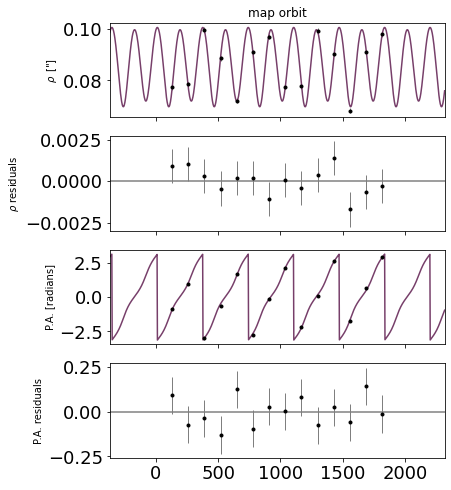

In [556]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

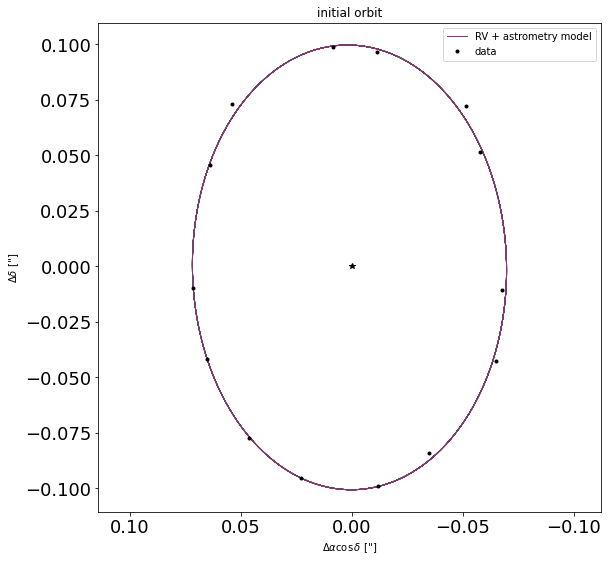

In [557]:
fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_save"] * np.cos(map_soln["theta_save"])  # X is north
ys = map_soln["rho_save"] * np.sin(map_soln["theta_save"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()


[365.22393524]


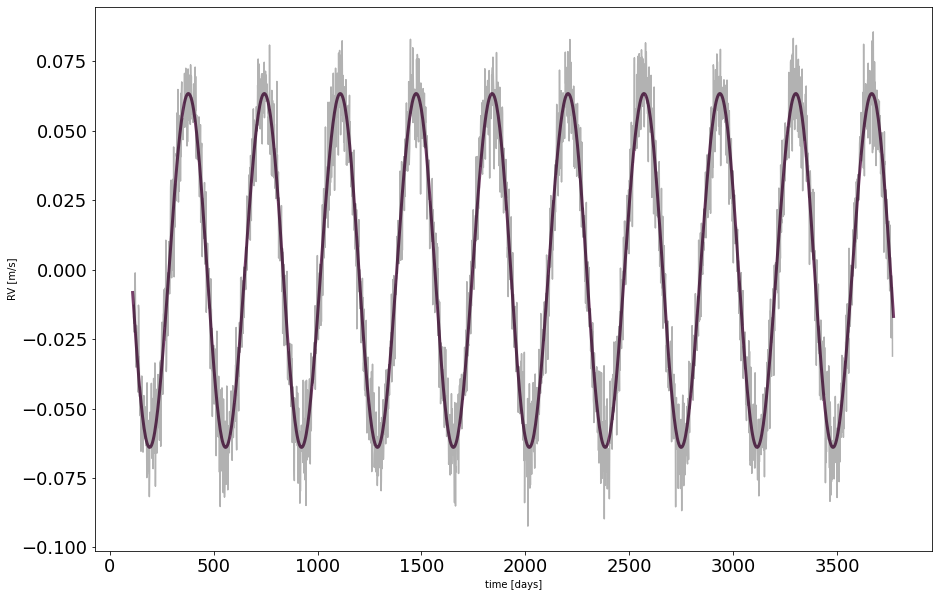

In [558]:
plt.figure(figsize=[15,10])
plt.plot(t, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.plot(x_rv, y_rv, color='k', alpha=0.3)
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
print(map_soln["P"])

Now let's sample the posterior.

In [559]:
np.random.seed(1234)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs_RV, log_theta_s, log_rho_s, a, m_planet, logK, cos_incl, t0, Omega, ecs, logP, m_plx]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
The acceptance probability does not match the target. It is 0.9671921433601169, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [560]:
import arviz as az

az.summary(
    trace,
    var_names=["P", "t0", "omega", "Omega", "incl", "ecc", "plx", "m_planet", "a_au"],
)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P[0],365.225,0.094,365.039,365.386,0.002,0.001,2419.0,1628.0,1.00
t0[0],103.454,0.519,102.483,104.402,0.012,0.008,1960.0,1384.0,1.00
omega[0],1.853,0.370,1.476,2.321,0.010,0.008,1552.0,1036.0,1.00
Omega[0],0.018,0.029,-0.035,0.071,0.001,0.001,1768.0,1284.0,1.00
incl,0.787,0.010,0.769,0.807,0.000,0.000,1769.0,1373.0,1.00
ecc[0],0.015,0.005,0.007,0.024,0.000,0.000,2034.0,1196.0,1.00
plx,0.099,0.010,0.081,0.118,0.001,0.000,286.0,306.0,1.01
m_planet,1.001,0.097,0.831,1.190,0.002,0.001,2394.0,1580.0,1.00
a_au,1.024,0.106,0.838,1.223,0.006,0.004,286.0,300.0,1.01


<ipython-input-561-c3e11f189014>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=["P", "t0", "omega", "Omega", "incl", "ecc", "plx", "m_planet", "a_au"])


array([[<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'t0'}>,
        <AxesSubplot:title={'center':'t0'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'Omega'}>,
        <AxesSubplot:title={'center':'Omega'}>],
       [<AxesSubplot:title={'center':'incl'}>,
        <AxesSubplot:title={'center':'incl'}>],
       [<AxesSubplot:title={'center':'ecc'}>,
        <AxesSubplot:title={'center':'ecc'}>],
       [<AxesSubplot:title={'center':'plx'}>,
        <AxesSubplot:title={'center':'plx'}>],
       [<AxesSubplot:title={'center':'m_planet'}>,
        <AxesSubplot:title={'center':'m_planet'}>],
       [<AxesSubplot:title={'center':'a_au'}>,
        <AxesSubplot:title={'center':'a_au'}>]], dtype=object)

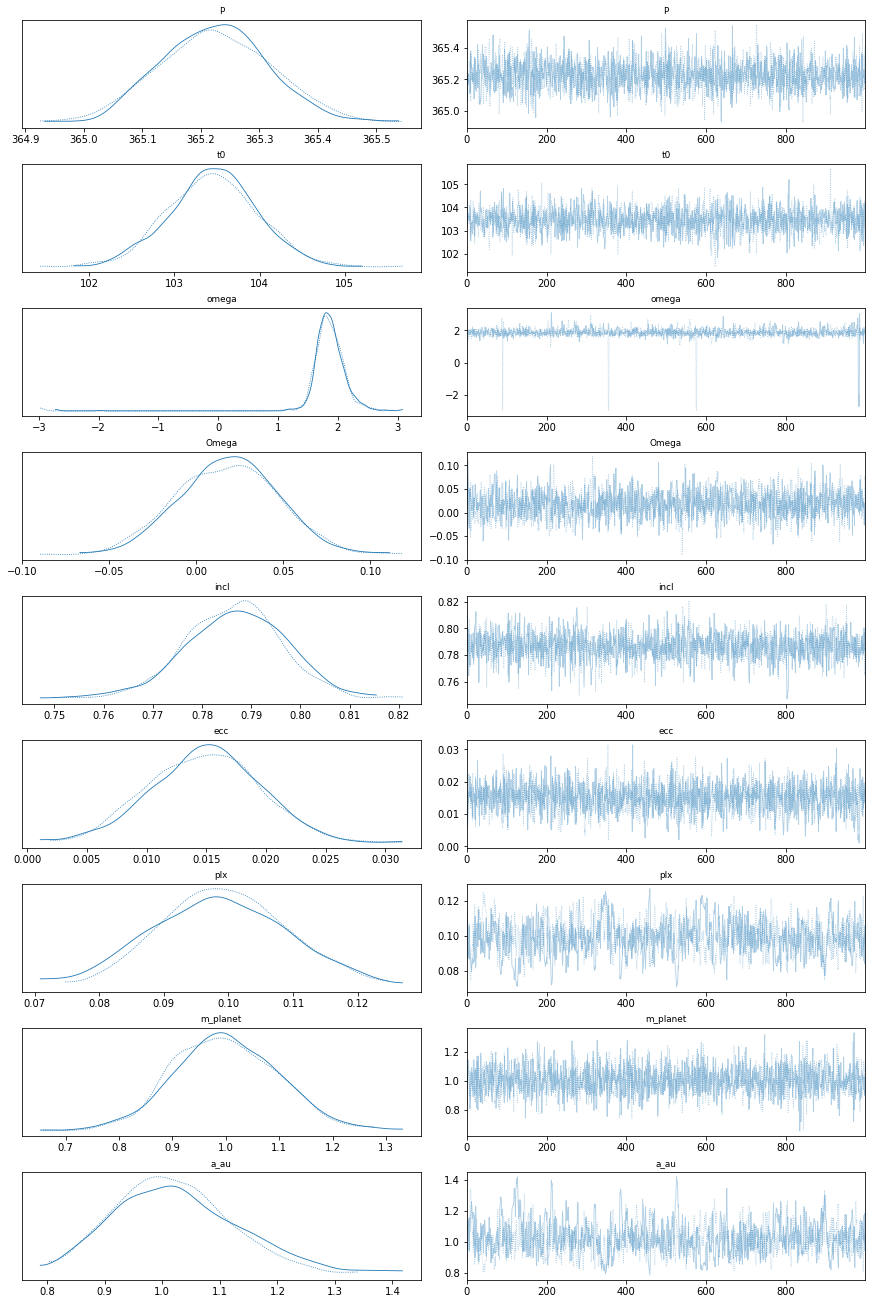

In [561]:
pm.traceplot(trace, var_names=["P", "t0", "omega", "Omega", "incl", "ecc", "plx", "m_planet", "a_au"])


In [562]:
truth_both = [P_jup, K_jup, e_jup, omega_jup, Omega_jup, inclination_jup, 0.1, m_jup/3.00273e-6, 1.0]

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

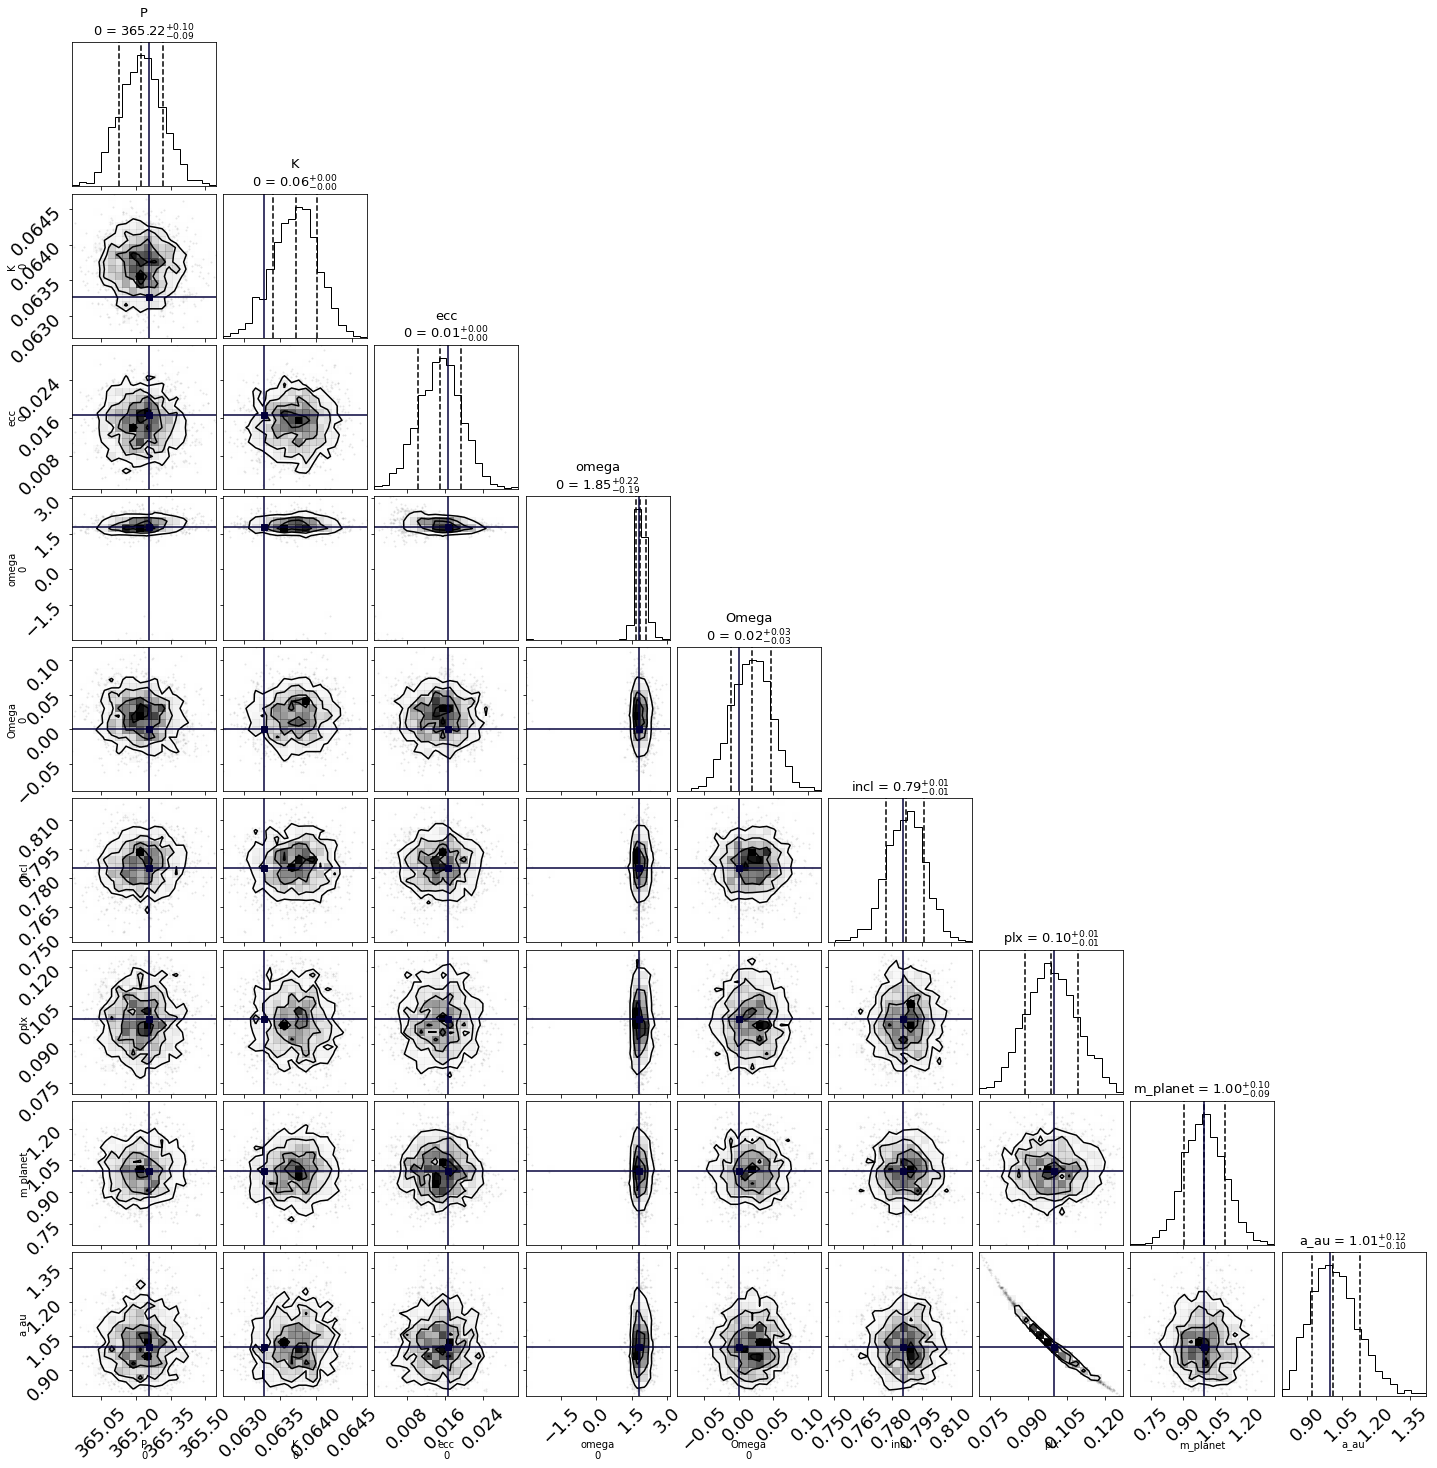

In [563]:
import corner

_ = corner.corner(
    trace, var_names=["P", "K", "ecc", "omega", "Omega", "incl", "plx", "m_planet", "a_au"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}, truths = truth_both, truth_color = "#03003a"
)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

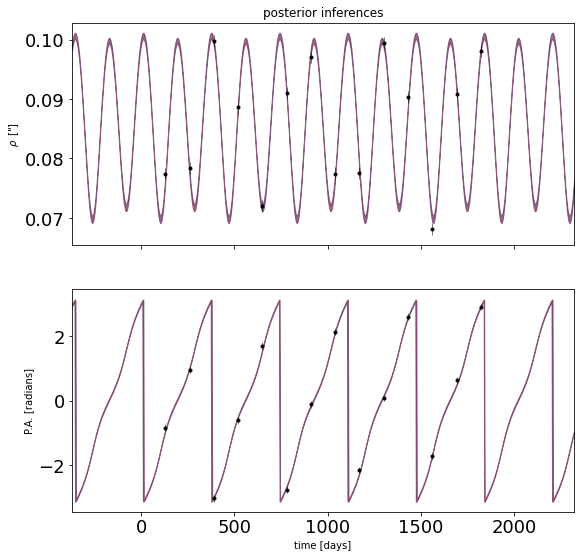

In [564]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel(r"time [days]")

tot_rho_err = np.sqrt(
    rho_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_rho_s"].values, axis=(0, 1)))
)
tot_theta_err = np.sqrt(
    theta_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_theta_s"].values, axis=(0, 1)))
)

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace.posterior["rho_save"].values, [16, 84], axis=(0, 1))
ax[0].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[1].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace.posterior["theta_save"].values, [16, 84], axis=(0, 1))
ax[1].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")